In [1]:
### import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

# Examples

Here we use our modified SEIR model to explore the population-level dynamics of some vaccines with well-known parameter values. Even though the vaccines used in the following examples were identified to be either leaky or all-or-nothing vaccines by [Farrington](https://pubmed.ncbi.nlm.nih.gov/12900143/), we ran both leaky and all-or-nothing models to compare the two mechanisms using the corresponding parameter values.

Also note that only the pre-transmission vaccination scenario was run because these vaccines are administered prior to transmission to prevent a potential outbreak within the population.

In [3]:
### define models
def seir (y, t, beta, sigma, gamma):    
    s, e, i, r = y
    dsdt = - beta*s*i
    dedt = beta*s*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    
    return dsdt, dedt, didt, drdt

def modified_seir(y, t, beta, sigma, gamma, f, epsL, epsA, v):
    s, v_es, v_rs, e, i, r = y
    dsdt = - beta*s*i - f*(1-(v_es+v_rs)/v)*s
    dvesdt = f*(1-epsA)*(1-(v_es+v_rs)/v)*s - beta*v_es*i
    dvrsdt = f*epsA*(1-(v_es+v_rs)/v)*s - (1-epsL)*beta*v_rs*i
    dedt = beta*s*i + beta*v_es*i + (1-epsL)*beta*v_rs*i - sigma*e
    didt = sigma*e - gamma*i
    drdt = gamma*i
    return dsdt, dvesdt, dvrsdt, dedt, didt, drdt

## Pertussis (Whooping Cough)

The parameter values used were based on [Ameri et al.](www.ncbi.nlm.nih.gov/pmc/articles/PMC6568137/) and modified such that the units align with our model.The vaccine efficacy was from [Schwartz et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5088088/). They reported the effectiveness of the vaccine to decline over time, so we used the value given for 8 or more years after vaccination. 

Note that we assumed vaccination happens all at once.

In [8]:
### run model
# set parameters
beta = 0.9; sigma = 1/8; gamma = 1/14; f = 0; vmax = 0.868
s0 = 0.98; e0 = 0.01; i0 = 0.01; r0 = 0; y0 = s0, e0, i0, r0; t = np.arange(0, 200)
s0_vax = 0.98-vmax; e0_vax = 0.01; i0_vax = 0.01

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# leaky
epsL = 0.41; epsA = 1; 
v_es0_leaky = 0; v_rs0_leaky = vmax; y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0_vax, i0_vax, r0
sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T
vtot_leaky = v_es_leaky + v_rs_leaky

# all-or-nothing
epsL = 1; epsA = 0.41; 
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA; y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0_vax, i0_vax, r0
sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T
vtot_aon = v_es_aon + v_rs_aon

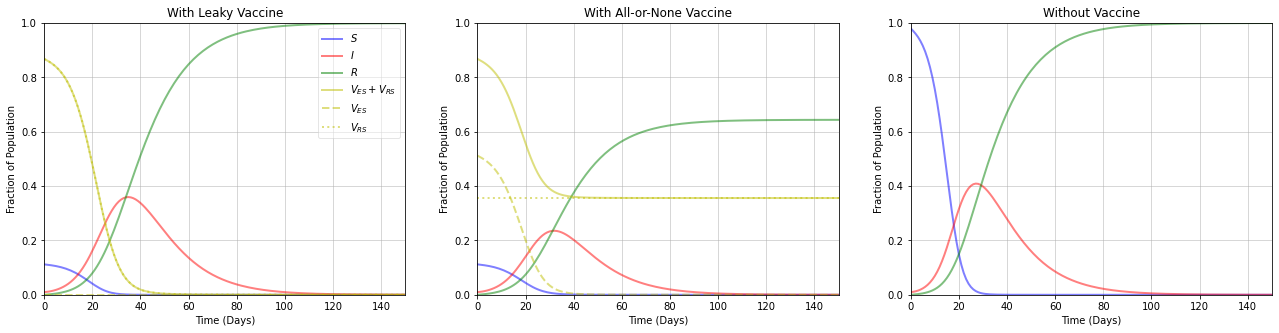

In [9]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

## Measles

The parameter values and initial conditions are from [Farman et al.](https://www.sciencedirect.com/science/article/pii/S209044791730151X), and the vaccine efficacy was from [Serres et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2271410/).

In [12]:
### run model
# set parameters
beta = 0.01; sigma = 0.01; gamma = 0.2; f = 0; vmax = 0.25
s0 = 0.6; e0 = 0.25; i0 = 0.1; r0 = 0.05; y0 = s0, e0, i0, r0; t = np.arange(0, 200)
s0_vax = 0.6-vmax; e0_vax = 0.25; i0_vax = 0.1

# no vaccination
sim = odeint(seir, y0, t, args=(beta, sigma, gamma))
s, e, i, r = sim.T

# leaky
epsL = 0.94; epsA = 1; 
v_es0_leaky = 0; v_rs0_leaky = vmax; y0_vax_leaky = s0_vax, v_es0_leaky, v_rs0_leaky, e0_vax, i0_vax, r0
sim_leaky = odeint(modified_seir, y0_vax_leaky, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_leaky, v_es_leaky, v_rs_leaky, e_leaky, i_leaky, r_leaky = sim_leaky.T
vtot_leaky = v_es_leaky + v_rs_leaky

# all-or-nothing
epsL = 1; epsA = 0.94; 
v_es0_aon = vmax*(1-epsA); v_rs0_aon = vmax*epsA; y0_vax_aon = s0_vax, v_es0_aon, v_rs0_aon, e0_vax, i0_vax, r0
sim_aon = odeint(modified_seir, y0_vax_aon, t, args=(beta, sigma, gamma, f, epsL, epsA, vmax))
s_aon, v_es_aon, v_rs_aon, e_aon, i_aon, r_aon = sim_aon.T
vtot_aon = v_es_aon + v_rs_aon

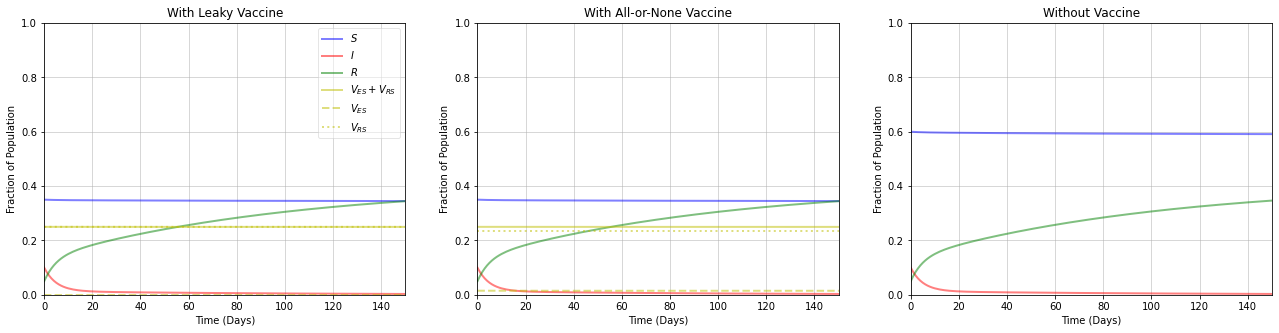

In [13]:
### plot figure
fig = plt.figure(facecolor='w', figsize=(22,5))

ax1 = fig.add_subplot(131, axisbelow=True)
ax1.plot(t, s_leaky, 'b', alpha=0.5, lw=2, label='$S$')
ax1.plot(t, i_leaky, 'r', alpha=0.5, lw=2, label='$I$')
ax1.plot(t, r_leaky, 'g', alpha=0.5, lw=2, label='$R$')
ax1.plot(t, vtot_leaky, 'y', alpha=0.5, lw=2, label='$V_{ES} + V_{RS}$')
ax1.plot(t, v_es_leaky, 'y--', alpha=0.5, lw=2, label='$V_{ES}$')
ax1.plot(t, v_rs_leaky, 'y:', alpha=0.5, lw=2, label='$V_{RS}$')
ax1.set_title("With Leaky Vaccine")
ax1.set_ylim(0, 1); ax1.set_xlim(0, 150)
ax1.set_ylabel("Fraction of Population")
ax1.set_xlabel('Time (Days)')
ax1.grid(linewidth=0.5)
legend = ax1.legend(); legend.get_frame().set_alpha(0.5)

ax2 = fig.add_subplot(132, axisbelow=True)
ax2.plot(t, s_aon, 'b', alpha=0.5, lw=2)
ax2.plot(t, i_aon, 'r', alpha=0.5, lw=2)
ax2.plot(t, r_aon, 'g', alpha=0.5, lw=2)
ax2.plot(t, vtot_aon, 'y', alpha=0.5, lw=2)
ax2.plot(t, v_es_aon, 'y--', alpha=0.5, lw=2)
ax2.plot(t, v_rs_aon, 'y:', alpha=0.5, lw=2)
ax2.set_title("With All-or-None Vaccine")
ax2.set_ylim(0, 1); ax2.set_xlim(0, 150)
ax2.set_ylabel("Fraction of Population")
ax2.set_xlabel('Time (Days)')
ax2.grid(linewidth=0.5)

ax3 = fig.add_subplot(133, axisbelow=True)
ax3.plot(t, s, 'b', alpha=0.5, lw=2)
ax3.plot(t, i, 'r', alpha=0.5, lw=2)
ax3.plot(t, r, 'g', alpha=0.5, lw=2)
ax3.set_title('Without Vaccine')
ax3.set_ylabel('Fraction of Population')
ax3.set_xlabel('Time (Days)')
ax3.set_ylim(0, 1); ax3.set_xlim(0, 150)
ax3.grid(linewidth=0.5)

#plt.savefig('seir_example', bbox_inches='tight')

As seen in the figures above, there are regimes in which the two vaccine failure mechanisms demonstrate a significant difference in the resulting recovered population as well as regimes where not much difference is observed. Thus, it is important to consider the two different mechanisms when modeling the impact of vaccination on a population.